# MRI phantom

Silia Georgaki

## Description

Given the section from MRI phantom above, try point of interest
localization techniques to extract the location of the intersections of
the black grid. Propose and test ways to calculate the geometric
deformation based on the circular shape of the phantom and the black
grid.

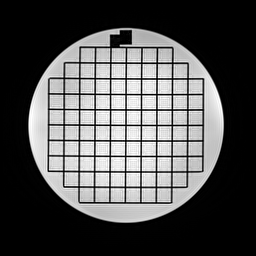

# Import Packages

In [1]:
import cv2
import numpy as np
import pydicom
import matplotlib.pyplot as plt
import scipy.ndimage

# Load File and save as png

Firstly, the dicom file is loaded and a png file is created.

Phantom has shape:  (256, 256, 3)

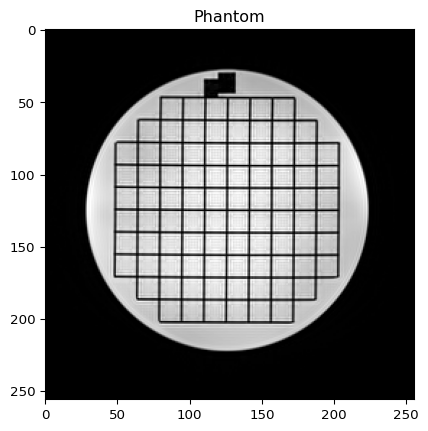

In [2]:
dicom_file = pydicom.dcmread('MR.zzzMRI_QA.5.dcm')
phantom_img = dicom_file.pixel_array
img = plt.imsave('phantom.png', phantom_img, cmap = 'gray')
img = cv2.imread('phantom.png')

# Display phantom
figure = plt.figure("phantom")
plt.imshow(img, cmap = plt.cm.gray)
plt.title('Phantom')
print("Phantom has shape: ", img.shape)

# Points of Interest

To identify points of interest, the Shi-Tomasi corner detection function
is used. This method finds corners by suggesting that values above a
certain threshold are corners.

In [3]:
# Shi-Tomasi corner detection function

image = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

def shi_tomasi_corner_detection(image, max_corners = 115, quality_level = 0.1, min_distance = 10):

    # Gray image
    gray_image = image.copy()

    # Detect Shi-Tomasi corners
    corners = cv2.goodFeaturesToTrack(gray_image, max_corners, quality_level, min_distance)

    # Convert corners values to integers for drawing circles
    corners = np.int0(corners)

    # Draw circles on the corners and store their coordinates
    corner_points = []
    for corner in corners:
        x, y = corner.ravel()
        image = cv2.circle(image, (x, y), 3, (255, 0, 0), -1)
        corner_points.append([x, y])

    # Display the image with detected corners
    plt.figure()
    plt.imshow(image, cmap = plt.cm.gray)
    plt.title("Shi-Tomasi Corners")
    plt.show()

    return corner_points

Then, the function is called.

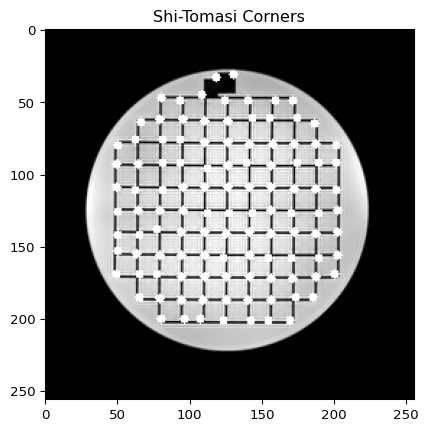

[[139, 92], [141, 79], [141, 109], [112, 127], [112, 96], [141, 140], [110, 140], [143, 127], [174, 92], [156, 141], [123, 158], [110, 109], [141, 171], [172, 110], [126, 78], [110, 78], [110, 156], [125, 171], [110, 171], [125, 141], [156, 109], [154, 158], [170, 127], [157, 79], [156, 94], [125, 187], [172, 79], [141, 156], [172, 140], [126, 109], [126, 63], [77, 138], [94, 156], [81, 111], [95, 109], [79, 156], [110, 63], [93, 92], [93, 76], [156, 125], [94, 171], [79, 125], [155, 61], [156, 172], [143, 61], [126, 94], [189, 92], [62, 111], [95, 62], [174, 61], [187, 141], [50, 142], [189, 127], [201, 92], [140, 187], [94, 140], [95, 125], [170, 158], [189, 158], [187, 110], [65, 169], [156, 187], [127, 127], [94, 187], [81, 92], [77, 169], [81, 76], [109, 187], [118, 33], [50, 153], [49, 109], [64, 125], [187, 79], [124, 49], [65, 142], [173, 185], [64, 93], [62, 76], [171, 172], [50, 126], [202, 125], [187, 171], [159, 49], [49, 93], [63, 155], [185, 185], [65, 185], [79, 186], [1

In [4]:
img1 = image.copy()
# Points of Interest using Shi-Tomasi corner detection
points1 = shi_tomasi_corner_detection(img1)
print(points1)

# Distortion Function

To attempt to calculate how much an image has been distorted, an
implementation of different distortions is needed. The function above is
used to apply different known distortions based on two numbers $k_1$ and
$k_2$. Specifically:

-   Barrel distortion: $k_1$, $k_2$ \> 0
-   Pincushion distortion: $k_1$, $k_2$ \< 0
-   Mustache distortion: $k_1$ \> 0 & $k_2$ \< 0

In [5]:
def distortion(image_to_distort, k_1, k_2):
    h, w = image_to_distort.shape[:2]
    xd, yd = np.meshgrid(np.arange(w), np.arange(h))  # meshgrid for interpolation mapping
    # center and scale the grid for radius calculation (distance from center of image)
    xd_c = w / 2
    yd_c = h / 2
    xd = xd - xd_c
    yd = yd - yd_c
    xd = xd / xd_c
    yd = yd / yd_c

    radius = np.sqrt(xd**2 + yd**2)  # distance from the center of the image
    m_r = 1 + k_1 * radius + k_2 * radius**2  # radial distortion model

    # apply the model
    xd = xd * m_r
    yd = yd * m_r

    # reset all the shifting
    xd = xd * xd_c + xd_c
    yd = yd * yd_c + yd_c

    # create a coordinate array for scipy.ndimage.map_coordinates
    coordinates = np.array([yd.ravel(), xd.ravel()])

    distorted_img = scipy.ndimage.map_coordinates(image_to_distort, coordinates)
    distorted_img.resize(image_to_distort.shape)
    return distorted_img

For each distortion we save the points of interest.

## Barel distortion

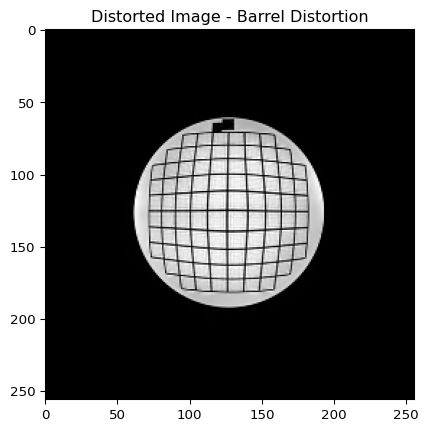

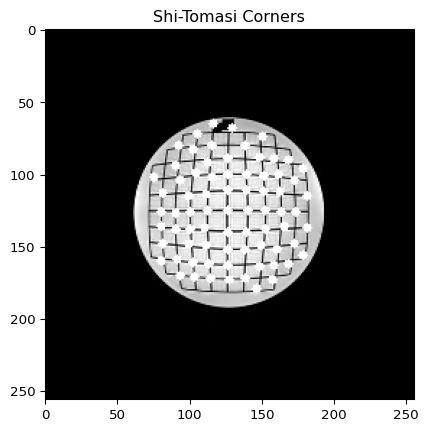

In [6]:
img2 = image.copy()
distorted_barrel = distortion(img2, 0.9, 0.08)
plt.figure()
plt.imshow(distorted_barrel, cmap = 'gray')
plt.title("Distorted Image - Barrel Distortion")
plt.show()
points2 = shi_tomasi_corner_detection(distorted_barrel)

## Pincushion distortion

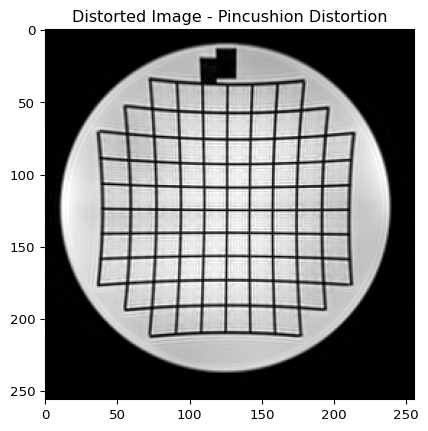

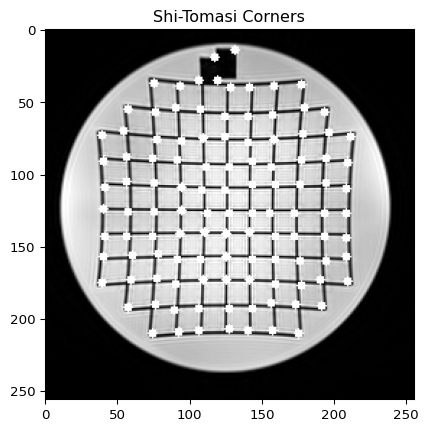

In [7]:
img3 = image.copy()
distorted_pincushion = distortion(img3, -0.08, -0.09)
plt.figure()
plt.imshow(distorted_pincushion, cmap = 'gray')
plt.title("Distorted Image - Pincushion Distortion")
plt.show()
points3 = shi_tomasi_corner_detection(distorted_pincushion)

## Mustache distortion

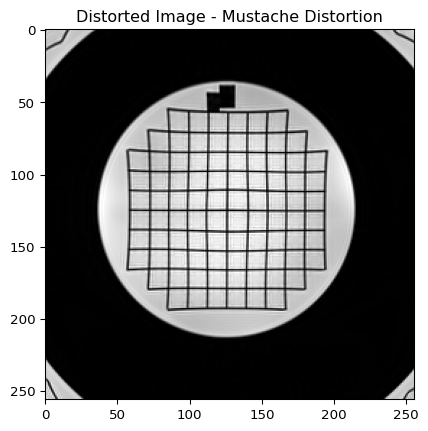

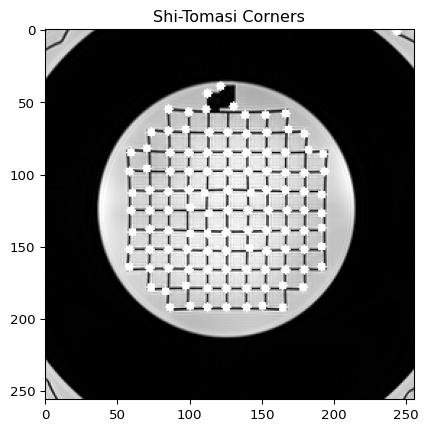

In [8]:
img4 = image.copy()
distorted_mustache = distortion(img4, 0.7, -0.8)
plt.figure()
plt.imshow(distorted_mustache, cmap='gray')
plt.title("Distorted Image - Mustache Distortion")
plt.show()
points4 = shi_tomasi_corner_detection(distorted_mustache)

# Measure distortions

After calculating the points of interest, the average distance between
the points of interest in the original and distorted images is
determined for each distortion.

In [9]:
def calculate_average_distance(points1, points2):
    distances = []

    for [x1, y1] in points1:
        for [x2, y2] in points2:
            D = (x2 - x1)**2 + (y2 - y1)**2
            distances.append(D)

    if len(distances) == 0:
        return 0  # Avoid division by zero if no distances are calculated

    average_distance = sum(distances) / len(distances)
    return average_distance

## Results

In [10]:
average_distance_1_2 = calculate_average_distance(points1, points2)
print("\nAverage distance of the points of interest of the original image and the points of interest of the barrel distortion:" ,average_distance_1_2)

average_distance_1_3 = calculate_average_distance(points1, points3)
print("\nAverage distance of the points of interest of the original image and the points of interest of the pincushion distortion:" ,average_distance_1_3)

average_distance_1_4 = calculate_average_distance(points1, points4)
print("\nAverage distance of the points of interest of the original image and the points of interest of the mustache distortion:" ,average_distance_1_4)


Average distance of the points of interest of the original image and the points of interest of the barrel distortion: 6006.473094716338

Average distance of the points of interest of the original image and the points of interest of the pincushion distortion: 9257.680421492922

Average distance of the points of interest of the original image and the points of interest of the mustache distortion: 7614.891409266409

Based on the aforementioned results, it is evident that the Pincushion
distortion yields a more distorted result in this case.